In [1]:
import os
import sys

sys.path.append('../')

In [2]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from benchmark.data import read_tep_data

In [3]:
from scipy.linalg import sqrtm
from sklearn.manifold import MDS

In [4]:
def estimate_bures_wasserstein(Xs, Xt):
    mean_s = Xs.mean(axis=0)
    mean_t = Xt.mean(axis=0)
    
    cov_s = np.cov(Xs.T)
    cov_t = np.cov(Xt.T)
    
    sqrt_cov_s = sqrtm(cov_s)
    
    mean_dist = np.linalg.norm(mean_s - mean_t) ** 2
    cov_dist = np.trace(cov_s) + np.trace(cov_t) - 2 * np.trace(
        sqrtm(sqrt_cov_s @ cov_t @ sqrt_cov_s)
    )
    
    return mean_dist + cov_dist

In [5]:
plt.rcParams['font.size'] = 18
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)

In [6]:
X, Y, d = read_tep_data(
    base_path='../tep_data/benchmark',
    modes=list(range(1, 7)),
    normalization="standardization",
    return_domain=True,
    as_list=False,
    channels_first=True,
    one_hot_labels=True
)

In [7]:
X.shape

torch.Size([17289, 34, 600])

## Qualitative Analysis

In [8]:
mode1, mode2 = 1, 2

/home/efernand/anaconda3/envs/OptimalTransport/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/efernand/anaconda3/envs/OptimalTransport/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/efernand/anaconda3/envs/OptimalTransport/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/efernand/anaconda3/envs/OptimalTransport/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/efernand/anaconda3/envs/OptimalTransport/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/efernand/anaconda3/envs/OptimalTransport/lib/python3.8/site-packages/numpy/core/_m

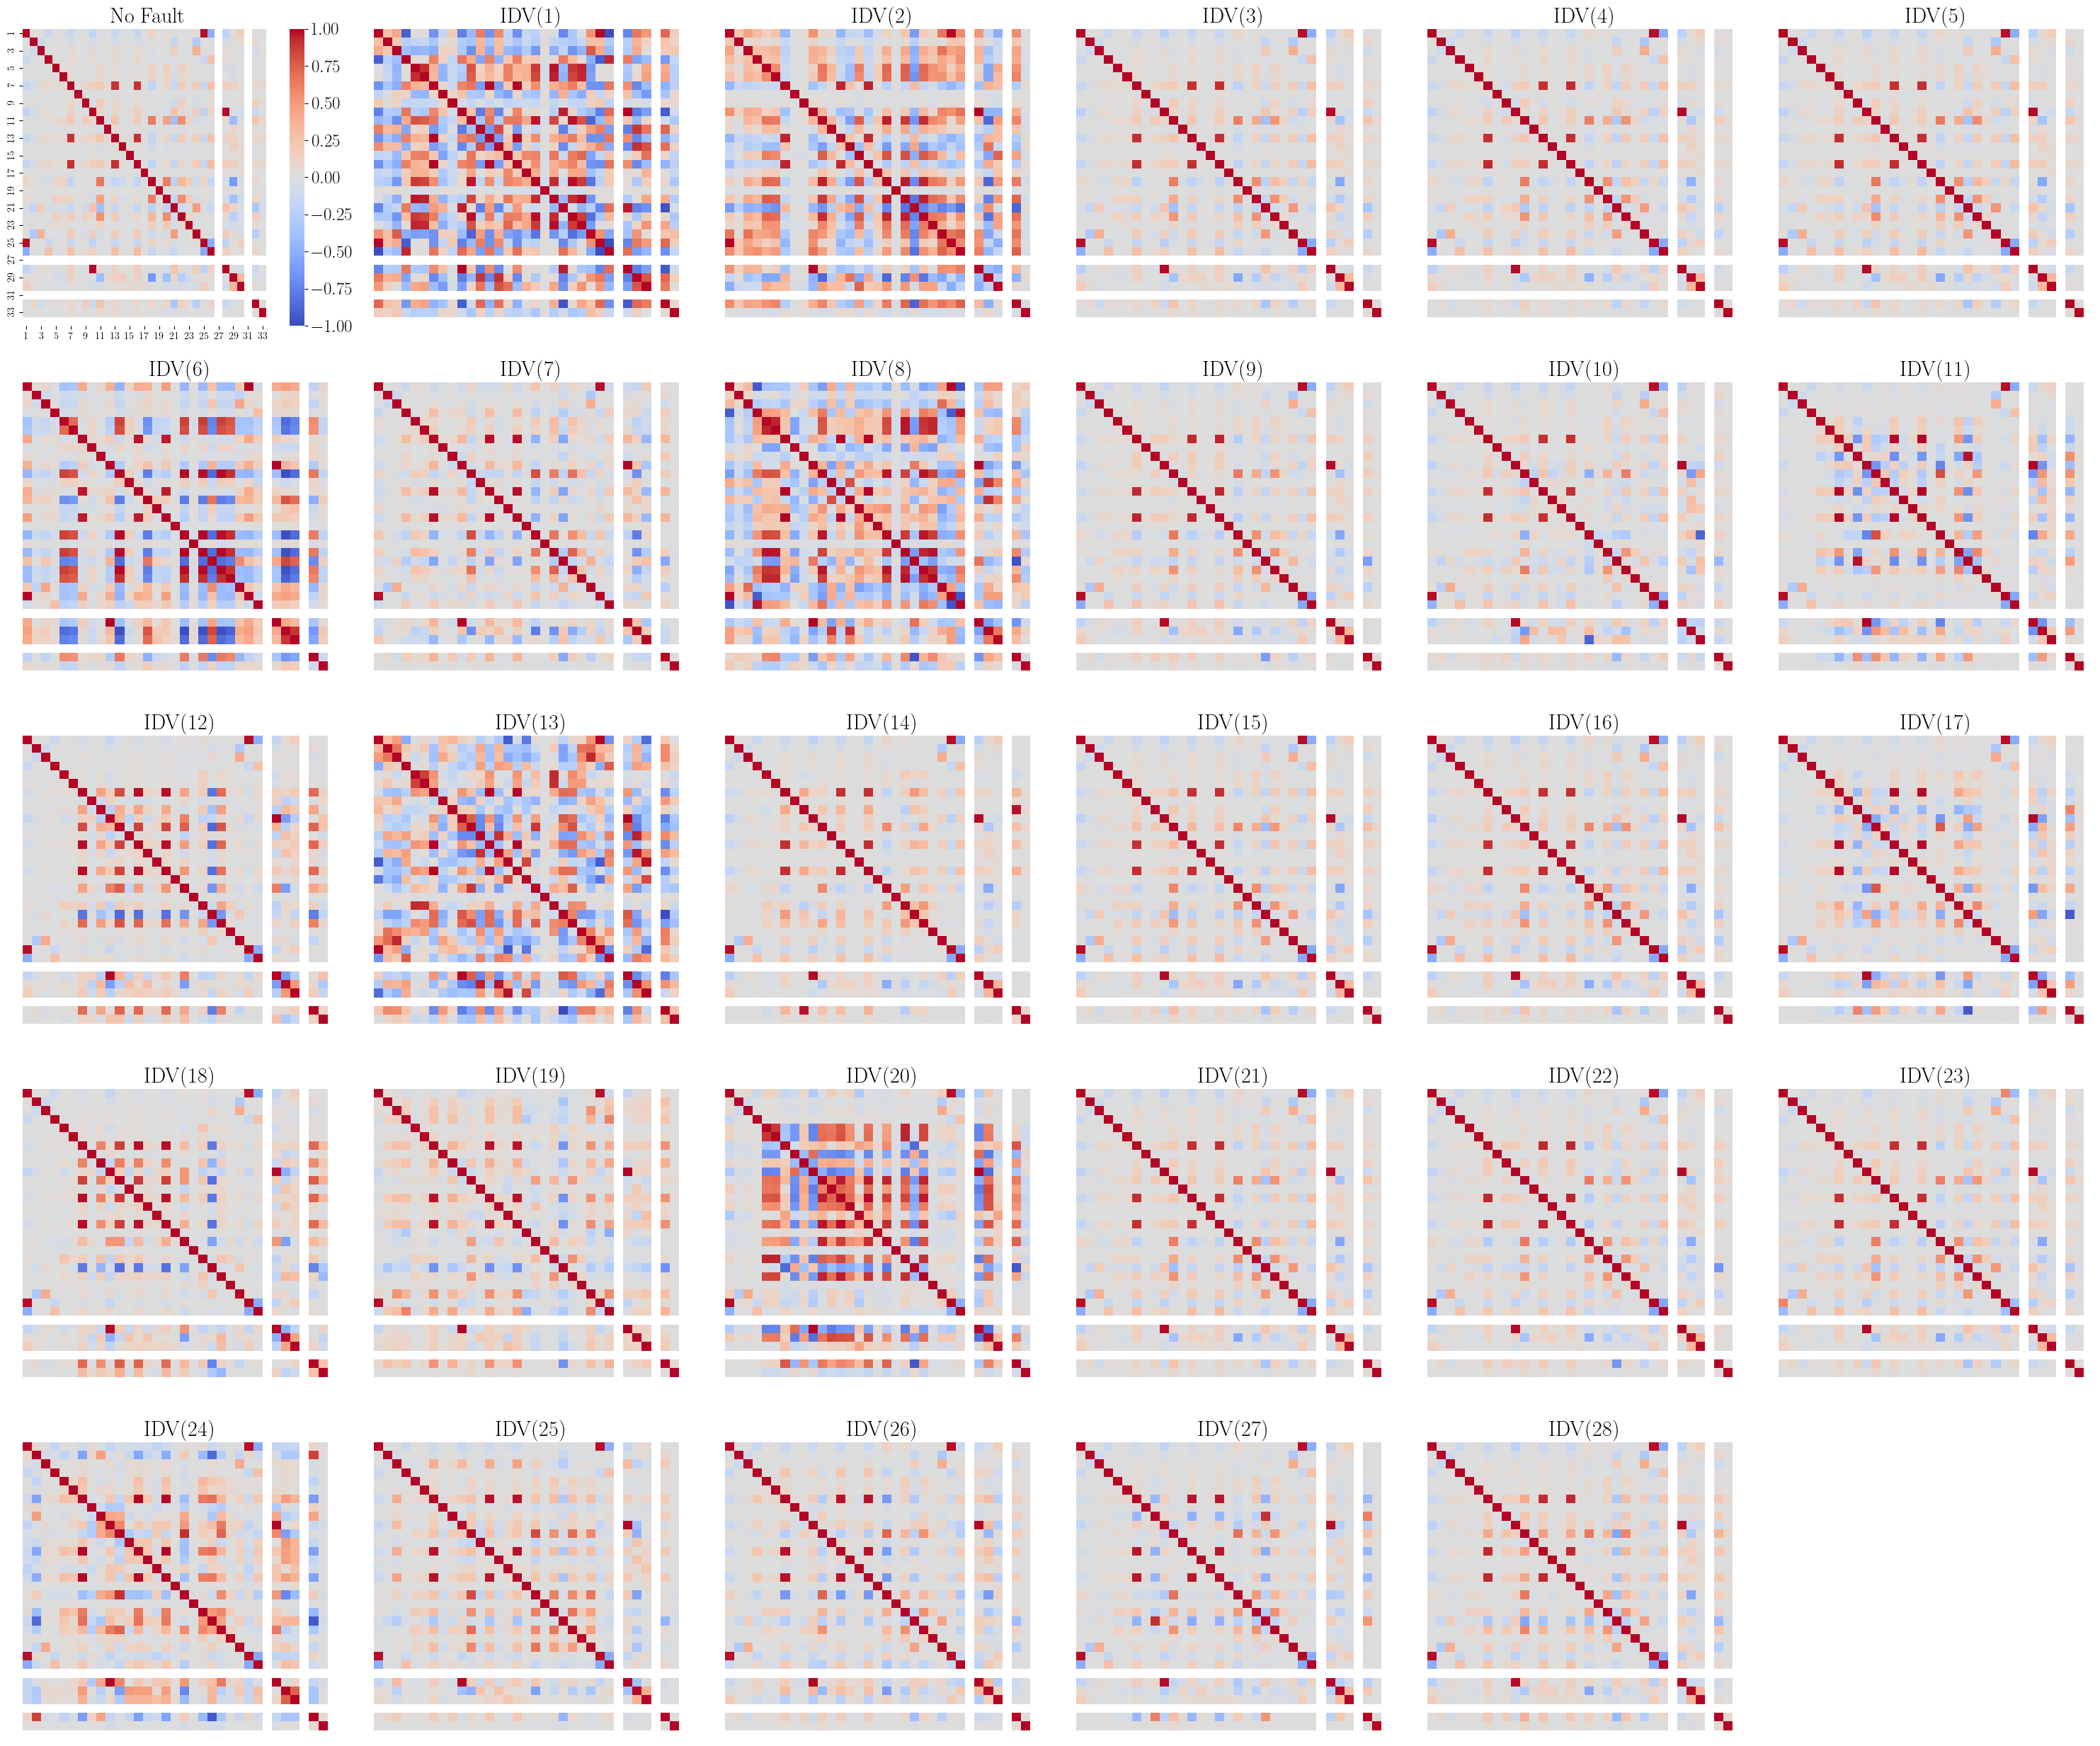

In [9]:
fig, axes = plt.subplots(5, 6, figsize=(30, 25))

ax = axes.flatten()[0]
ind = np.where(d == mode1)[0]
Xs, Ys = X[ind], Y[ind]
data = Xs[np.where(Ys.argmax(dim=1) == 0)[0]].numpy().transpose([0, 2, 1])
data = data.reshape(len(data) * 600, 34)
sns.heatmap(np.corrcoef(data.T), vmin=-1, vmax=+1, cmap='coolwarm', ax=ax, cbar=True)
ax.set_title(f"No Fault")
_ = ax.set_xticks(np.arange(0, 34, 2) + 0.5, np.arange(0, 34, 2) + 1, fontsize=10)
_ = ax.set_yticks(np.arange(0, 34, 2) + 0.5, np.arange(0, 34, 2) + 1, fontsize=10)

for i, ax in enumerate(axes.flatten()[1:]):
    data = Xs[np.where(Ys.argmax(dim=1) == i + 1)[0]].numpy().transpose([0, 2, 1])
    data = data.reshape(len(data) * 600, 34)
    sns.heatmap(np.corrcoef(data.T), vmin=-1, vmax=+1, cmap='coolwarm', ax=ax, cbar=False)
    ax.set_title(f"IDV({i + 1})")
    ax.set_xticks([])
    ax.set_yticks([])
axes.flatten()[-1].axis('off')
axes.flatten()[-1].set_title("")
plt.tight_layout()

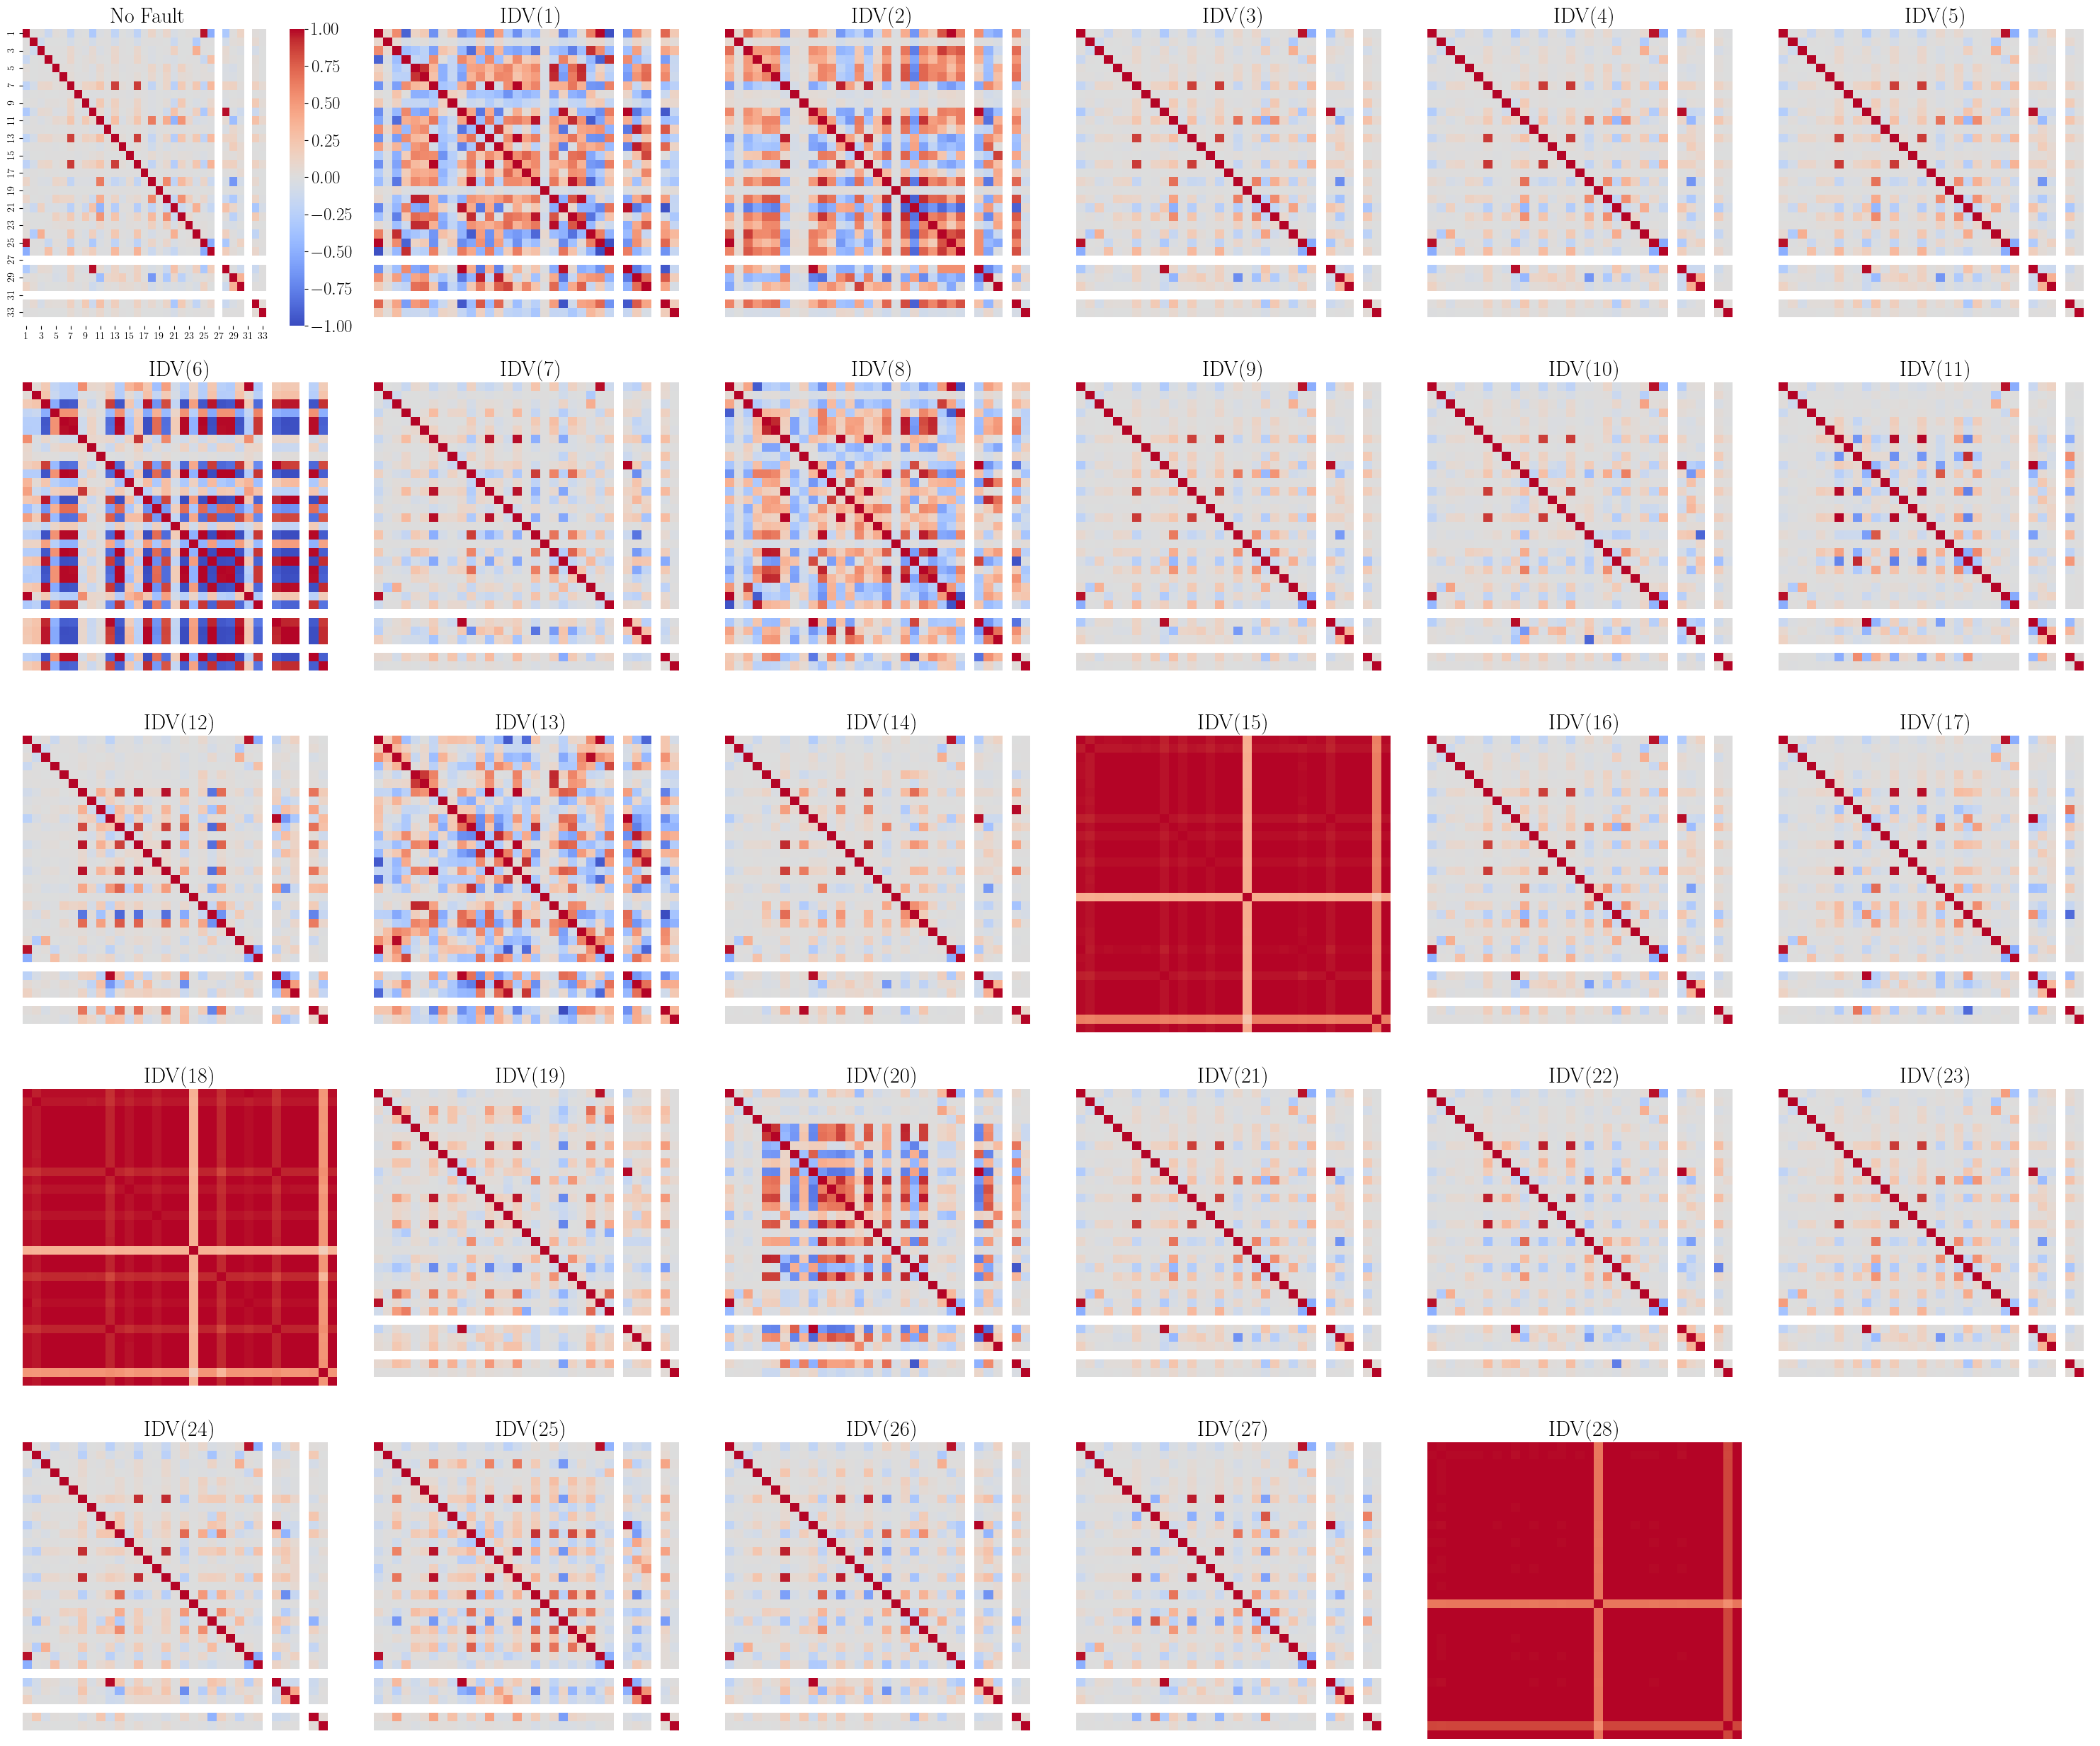

In [10]:
fig, axes = plt.subplots(5, 6, figsize=(30, 25))

ax = axes.flatten()[0]
ind = np.where(d == mode2)
Xs, Ys = X[ind], Y[ind]
data = Xs[np.where(Ys.argmax(dim=1) == 0)[0]].numpy().transpose([0, 2, 1])
data = data.reshape(len(data) * 600, 34)
sns.heatmap(np.corrcoef(data.T), vmin=-1, vmax=+1, cmap='coolwarm', ax=ax, cbar=True)
ax.set_title(f"No Fault")
_ = ax.set_xticks(np.arange(0, 34, 2) + 0.5, np.arange(0, 34, 2) + 1, fontsize=10)
_ = ax.set_yticks(np.arange(0, 34, 2) + 0.5, np.arange(0, 34, 2) + 1, fontsize=10)

for i, ax in enumerate(axes.flatten()[1:]):
    data = Xs[np.where(Ys.argmax(dim=1) == i + 1)[0]].numpy().transpose([0, 2, 1])
    data = data.reshape(len(data) * 600, 34)
    sns.heatmap(np.corrcoef(data.T), vmin=-1, vmax=+1, cmap='coolwarm', ax=ax, cbar=False)
    ax.set_title(f"IDV({i + 1})")
    ax.set_xticks([])
    ax.set_yticks([])
axes.flatten()[-1].axis('off')
axes.flatten()[-1].set_title("")
plt.tight_layout()

## Quantitative Analysis

In [11]:
C = np.zeros([6, 6])

for i in range(6):
    for j in range(i + 1, 6):
        data_i = X[np.where(d == i + 1)[0]].reshape(-1, 34)
        data_i += 1e-6 * torch.randn_like(data_i)
        data_j = X[np.where(d == j + 1)[0]].reshape(-1, 34)
        data_j += 1e-6 * torch.randn_like(data_j)
        C[i, j] = estimate_bures_wasserstein(data_i, data_j)
        C[j, i] = C[i, j]
        
        print(i, j, C[i, j])

0 1 4.234139768374714
0 2 0.8217211256907584
0 3 0.5141136747895063
0 4 0.324235419784693
0 5 0.6051468239349325
1 2 7.997993018387561
1 3 2.546656674116136
1 4 2.6144225404243855
1 5 7.024125690803275
2 3 1.756332826003034
2 4 1.9002488652341647
2 5 0.05090347550229637
3 4 0.3102998151656957
3 5 1.26441089000968
4 5 1.484551619004776


In [12]:
avg_vec = []

for i in range(6):
    v = C[i, :]
    avg_vec.append(v[v != 0].mean())

avg_vec = np.array(avg_vec)[None, :]

Text(25.08143848183245, 0.5, 'Target Mode')

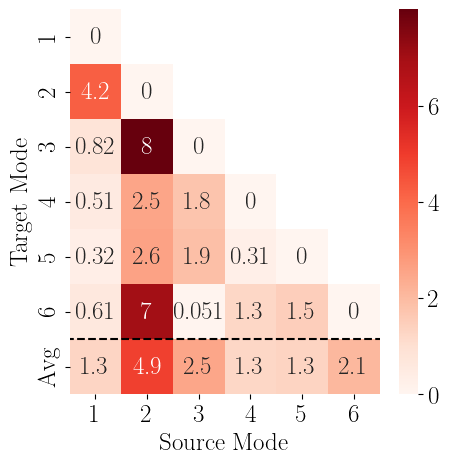

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(np.concatenate([C, avg_vec], axis=0), cmap='Reds', annot=True,
            mask=np.concatenate([np.triu(C, k=0), np.zeros_like(avg_vec)], axis=0),
            ax=ax)
ax.plot([-0.5, 6.5], [6.0, 6.0], 'k--')

_ = ax.set_xticks([i + 0.5 for i in range(6)], [i + 1 for i in range(6)])
_ = ax.set_yticks([i + 0.5 for i in range(7)], [i + 1 for i in range(6)] + ['Avg',])
ax.set_xlabel("Source Mode")
ax.set_ylabel("Target Mode")

In [14]:
embeddings = MDS(n_components=2, dissimilarity='precomputed').fit_transform(C)

Text(0, 0.5, 'Embedding Dim 2')

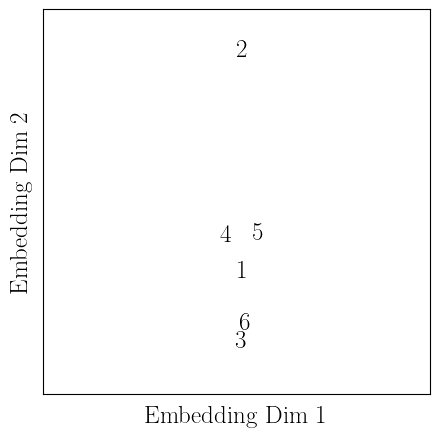

In [15]:
plt.figure(figsize=(5, 5))
for i, (x, y) in enumerate(embeddings):
    plt.text(x=x, y=y, s=f"{i + 1}")
plt.xlim([embeddings[:, 0].min() - 1, embeddings[:, 0].max() + 1])
plt.ylim([embeddings[:, 1].min() - 1, embeddings[:, 1].max() + 1])
plt.xticks([])
plt.yticks([])
plt.xlabel("Embedding Dim 1")
plt.ylabel("Embedding Dim 2")